## Access to the DB

### SQLite

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine, MetaData
from sqlalchemy.orm import sessionmaker
import pandas as pd

# the following example will depend on a sqlite db
sqlfile="../churn.db"
engine = create_engine(f"sqlite:///{sqlfile}")
session = sessionmaker(bind=engine)()

from churnmodels.schema import Observation,ActiveWeek, ActivePeriod, Account, Metric, MetricName, Subscription, Event, EventType


### PostGres

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd

from churnmodels.schema import get_schema, get_db_uri

options = {"user": "postgres",
           "pass": "password",
           "dbname": "churn",
           "schema": "biznet1"
           #"host" : "localhost" # ...if needed
           #"port" : "5432" # ...if needed
           }

if True:
    # tables is a (dynamical) module containg Wrapper classes for our data base
    T=get_schema(options)

    # connect to the database
    db_uri=get_db_uri(options, "postgres") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    engine.dialect.has_schema(engine, options["schema"]) 
    session = sessionmaker(bind=engine)()

    # ..how to bring all tables in T to the global namespace
    for tbl in T.__dict__.keys():
        if not tbl[0].isupper():
            continue
        exec(f"{tbl} = T.{tbl}")


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sqlalchemy import func, or_
import pandas as pd
import sqlparse

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

def pretty_sql(q1):
    # debug: looking at the SQL pretty printed
    text1=str(q1.statement.compile(engine, compile_kwargs={"literal_binds": True}))
    text2=sqlparse.format(text1, reindent=True, keyword_case='upper')
    return text2
    #print(text2)

#d_start_date = "2020-01-01"
#d_end_date = "2020-03-01"

d_start_date = "2020-03-01"
d_end_date = "2020-04-01"

metric_period=7
d_obs_start = "2020-02-09"
d_obs_end = "2020-05-10"


In [3]:
from sqlalchemy import func
if session.bind.dialect.name == "sqlite":
    # sqlite problematic when computing days
    to_days = lambda some_date: func.julianday(some_date)
else:
    # dummy func because of sqlite
    to_days = lambda some_date: some_date


## metric pair plot (§6.1)

In [19]:
from sqlalchemy import case, func, literal
import numpy as np

def get_dataset(d_obs_start, d_end_end, metric_period):
    fields=[
        Metric.account_id,
        Observation.observation_date,
        Observation.is_churn
    ]
    targets={}
    df_metricnames=pd.read_sql(session.query(MetricName).statement,engine)
    for index, row in df_metricnames.iterrows():
        newfield=func.sum(case([
            (Metric.metric_name_id == row.metric_name_id, Metric.metric_value)
            ], else_=0)).label(row.metric_name)
        fields.append(newfield)

    qr=session.query(*fields)\
        .join(Observation, Metric.account_id==Observation.account_id)\
        .filter(
            Metric.metric_time> func.DATE(to_days(Observation.observation_date)-metric_period), 
            Metric.metric_time<= Observation.observation_date)\
        .group_by(Metric.account_id, Metric.metric_time,
                  Observation.observation_date, Observation.is_churn)\
        .order_by(Observation.observation_date, Metric.account_id)

    #print(pretty_sql(qr))
    ddf=pd.read_sql(qr.statement, engine)
    ddf=ddf.set_index("account_id")
    return ddf

def get_active_customers():
    last_metric_time=session.query(func.DATE(func.max(Metric.metric_time))).one()[0] or 0
    last_metric_time=str(last_metric_time) # making a string, let the pretty print work for postgres...

    fields=[
        Metric.account_id,
        func.DATE(last_metric_time).label("last_metric_time"),
    ]
    targets={}
    df_metricnames=pd.read_sql(session.query(MetricName).statement,engine)
    for index, row in df_metricnames.iterrows():
        newfield=func.sum(case([
            (Metric.metric_name_id == row.metric_name_id, Metric.metric_value)
            ], else_=0)).label(row.metric_name)
        fields.append(newfield)

    qr=session.query(*fields)\
        .join(Subscription, Metric.account_id==Subscription.account_id)\
        .filter(
            func.DATE(Metric.metric_time) == last_metric_time, 
            func.DATE(Subscription.start_date) <= last_metric_time, 
            or_(func.DATE(Subscription.end_date) >= last_metric_time, Subscription.end_date==None)
            )\
        .group_by(Metric.account_id, "last_metric_time")\
        .order_by(Metric.account_id)

    #print(pretty_sql(qr))
    ddf=pd.read_sql(qr.statement, engine)
    return ddf

def dataset_stats(churn_data):
    if 'is_churn' in churn_data:
        churn_data['is_churn']=churn_data['is_churn'].astype(float)

    summary = churn_data.describe()
    summary = summary.transpose()
    #print(churn_data)

    summary['skew'] = churn_data.skew()
    summary['1%'] = churn_data.quantile(q=0.01)
    summary['99%'] = churn_data.quantile(q=0.99)
    summary['nonzero'] = churn_data.astype(bool).sum(axis=0) / churn_data.shape[0]

    summary = summary[ ['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max'] ]
    summary.columns = summary.columns.str.replace("%", "pct")
    return summary

def metric_scores(churn_data, stats, skew_thresh=4.0):
    data_scores = churn_data.copy()
    data_scores=data_scores.drop(['is_churn'],axis=1)

    stats=stats.drop('is_churn')
    skewed_columns=(stats['skew']>skew_thresh) & (stats['min'] >= 0)
    skewed_columns=skewed_columns[skewed_columns]

    for col in skewed_columns.keys():
        data_scores[col]=np.log(1.0+data_scores[col])
        stats.at[col,'mean']=data_scores[col].mean()
        stats.at[col,'std']=data_scores[col].std()

    data_scores=(data_scores-stats['mean'])/stats['std']
    data_scores['is_churn']=churn_data['is_churn'].astype('bool')
    return data_scores


# retrieving the metric pivot directly from the DB (not from a csv)
# see SQL in $4.5 dataset
dataset=get_dataset(d_obs_start, d_obs_end, metric_period)
active_customers=get_active_customers()
#print(dataset)


Index(['account_tenure', 'adview_per_month', 'dislike_per_month',
       'like_per_month', 'message_per_month', 'newfriend_per_month',
       'observation_date', 'post_per_month', 'reply_per_month',
       'unfriend_per_month', 'is_churn'],
      dtype='object')


<module 'matplotlib.pyplot' from 'C:\\bin\\Anaconda3\\envs\\fightchurn\\lib\\site-packages\\matplotlib\\pyplot.py'>

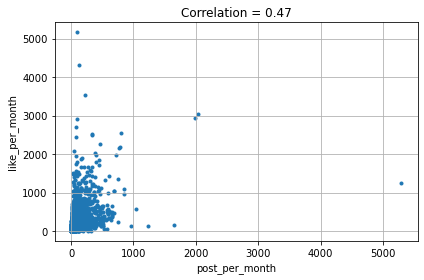

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def metric_pair_plot(churn_data, metric1='',metric2=''):
    met1_series = churn_data[metric1]
    met2_series = churn_data[metric2]

    corr = met1_series.corr(met2_series)

    plt.scatter(met1_series, met2_series, marker='.')

    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title('Correlation = %.2f' % corr)
    plt.tight_layout()
    plt.grid()
    return plt

dataset=get_dataset(d_obs_start, d_obs_end, metric_period)
stats=dataset_stats(dataset)
scores=metric_scores(dataset, stats)
print(scores.columns)

#metric_pair_plot(scores, "adview_per_month", "dislike_per_month")

metric_pair_plot(dataset, "post_per_month", "like_per_month")


<module 'matplotlib.pyplot' from 'C:\\bin\\Anaconda3\\envs\\fightchurn\\lib\\site-packages\\matplotlib\\pyplot.py'>

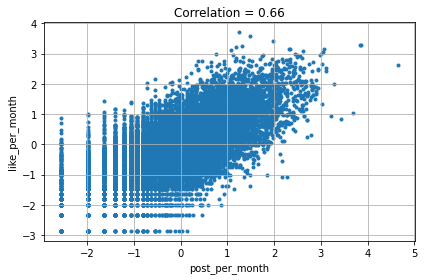

In [30]:
metric_pair_plot(scores, "post_per_month", "like_per_month")

## dataset correlation (§6.2)

In [31]:
def dataset_correlation_matrix(churn_data):
    churn_data = churn_data.reindex(sorted(churn_data.columns), axis=1)
    corr_df = churn_data.corr()
    return corr_df

corr=dataset_correlation_matrix(dataset)
print(corr)


                     account_tenure  adview_per_month  dislike_per_month  \
account_tenure             1.000000          0.041987           0.057664   
adview_per_month           0.041987          1.000000           0.304183   
dislike_per_month          0.057664          0.304183           1.000000   
is_churn                  -0.050813         -0.040692          -0.051904   
like_per_month             0.036772          0.523531           0.323022   
message_per_month          0.028683          0.043553           0.071427   
newfriend_per_month        0.081018          0.529937           0.354974   
post_per_month             0.044558          0.526942           0.300071   
reply_per_month            0.030852          0.035779           0.064865   
unfriend_per_month         0.064968          0.012885           0.011033   

                     is_churn  like_per_month  message_per_month  \
account_tenure      -0.050813        0.036772           0.028683   
adview_per_month    -0.0406

In [33]:
corr_scores_df=dataset_correlation_matrix(scores)
print(corr)


                     account_tenure  adview_per_month  dislike_per_month  \
account_tenure             1.000000          0.074926           0.084711   
adview_per_month           0.074926          1.000000           0.453882   
dislike_per_month          0.084711          0.453882           1.000000   
is_churn                  -0.050813         -0.080736          -0.074480   
like_per_month             0.093018          0.673893           0.453086   
message_per_month          0.083992          0.110510           0.140913   
newfriend_per_month        0.081018          0.530649           0.363833   
post_per_month             0.096382          0.663963           0.454367   
reply_per_month            0.066047          0.059097           0.101006   
unfriend_per_month         0.064968          0.012395           0.012715   

                     is_churn  like_per_month  message_per_month  \
account_tenure      -0.050813        0.093018           0.083992   
adview_per_month    -0.0807

## Apply metric groups (§6.3)

In [37]:
import numpy as np

import pandas as pd
import numpy as np
import os

def apply_metric_groups(score_data, load_mat_df):
    #data_2group = score_data.drop('is_churn',axis=1)
    data_2group = score_data
    load_mat_ndarray = load_mat_df.to_numpy()

    # Make sure the data is in the same column order as the rows of the loading matrix
    ndarray_2group = data_2group[load_mat_df.index.values].to_numpy()
    grouped_ndarray = np.matmul(ndarray_2group, load_mat_ndarray)

    churn_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=score_data.index)

    churn_data_grouped['is_churn'] = score_data['is_churn']
    return churn_data_grouped


churn_data_grouped=apply_metric_groups(scores, corr_scores_df)
print(churn_data_grouped)


           account_tenure adview_per_month dislike_per_month  is_churn  \
account_id                                                               
3               -0.691229         -1.66893          -1.96065     False   
27              -0.289346           2.2104           1.51512     False   
145             -0.330334           1.2155         -0.493824     False   
146            -0.0627163          2.49287           1.28426     False   
151             -0.143381        -0.243577          0.497302     False   
...                   ...              ...               ...       ...   
11930            -2.53727         -2.99121          -2.34057     False   
11944            -2.98068         -3.91413          -2.53546      True   
11996            -2.32131        -0.161065          0.118065     False   
11997            -2.35997        -0.449508         -0.978568     False   
12075            -2.70571         -5.04129          -4.55941     False   

           like_per_month message_per

## Find metric groups (§6.4)

## Ordered correlation (§6.5)